# <center>Store Sales Using Time Series Forecasting</center>


## Business Understanding
### Introduction
Accurate sales forecasting is essential for maximising inventory, resource allocation, and decision-making processes in the dynamic world of retail. In this project, we delve into the realm of time series forecasting for store sales, aiming to provide a robust predictive model for Favorita, a leading Ecuadorian-based grocery retailer. By harnessing the power of data and advanced analytics, we seek to enhance Favorita's operations, improve customer satisfaction, and drive business growth.

### Business Objective
The main objective of this project is to develop a robust and accurate time series forecasting model that predicts store sales for a wide range of products across Favorita stores. By leveraging historical sales data and relevant supplementary information, the model aims to provide reliable forecasts that enable Favorita to optimize its inventory management, resource allocation, and marketing strategies. The successful implementation of this model will contribute to improved operational efficiency, enhanced decision-making, and increased profitability for the retailer.

### Business Goals
The key business goals of this project include:

- Improved Inventory Management: Accurate sales predictions will enable Favorita to manage inventory levels efficiently. 

- Enhanced Resource Allocation: With precise sales forecasts, Favorita can allocate human resources and logistics more effectively, ensuring that stores have adequate staff and supplies to meet customer demand.

- Marketing and Promotion Strategies: By understanding the impact of promotions on sales, Favorita can tailor its marketing strategies to boost sales during specific periods. 

- Optimized Financial Planning: Accurate sales predictions facilitate better financial planning and budgeting.


### Data Reqirements
To successfully achieve the objectives of this project and build an accurate time series forecasting model for store sales, the following data is required:

1.  Historical Sales Data
        
2.  Transaction Data
        

3.  Store Metadata 
       

4.  Oil Price Data 
        

5.  Holidays and Events Data 
        



## Hypothesis:

- Null Hypothesis (H0): The intensity of promotion (onpromotion) does not have a significant impact on the average sales of products.

- Alternative Hypothesis (H1): The intensity of promotion (onpromotion) has a significant impact on the average sales of products.


### Questions

1.	Which dates have the lowest and highest sales for each year?

2.	Which stores are among the top 10 in terms of total sales?

3.	Did the sales data show any noticeable changes in sales patterns around the time of the 2016 earthquake?

4.	Which product families were the most frequently purchased (Top 5)?

5.	Is there a relationship between transactions and sales?

6.	Is there any association between oil prices and sales?



In [136]:
### Install required packages

#Libraries for sql
import pyodbc 
from dotenv import dotenv_values #import the dotenv_values function from the dotenv package
import warnings 
warnings.filterwarnings('ignore')

#libraries for handling data
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', None)

##data visualizations
from scipy import stats
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px


### Create a connection by accessing connection string with defined environment variables


In [2]:

# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')


# Get the values for the credentials you set in the '.env' file
database = environment_variables.get("DATABASE")
server = environment_variables.get("SERVER")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")

connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"


In [3]:
# Use the connect method of the pyodbc library and pass in the connection string.
connection = pyodbc.connect(connection_string)


In [4]:
# Now the sql query to get the data is what what you see below. 
query = "Select * from dbo.oil"
query1 = "Select * from dbo.holidays_events"
query2 = "Select * from dbo.stores"


## Data Understanding

### Data Collection
Data for this project will be collected from 3 places, a database, OneDrive and GitHub

### Data Description
The training data includes dates, store, and product information, whether that item was being promoted, as well as the sales numbers. Additional files include supplementary information that may be useful in building your models

**File Descriptions and Data Field Information**

train.csv

- The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.

- **store_nbr** identifies the store at which the products are sold.

- **family** identifies the type of product sold.

- **sales** gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).

- **onpromotion** gives the total number of items in a product family that were being promoted at a store at a given date.

test.csv

- The test data, having the same features as the training data. You will predict the target sales for the dates in this file.

- The dates in the test data are for the 15 days after the last date in the training data.

transaction.csv

- Contains date, store_nbr and transaction made on that specific date.

sample_submission.csv

- A sample submission file in the correct format.

stores.csv

- Store metadata, including city,state, type, and cluster.

- cluster is a grouping of similar stores.

oil.csv

- **Daily oil price** which includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and its economical health is highly vulnerable to shocks in oil prices.)

holidays_events.csv

- Holidays and Events, with metadata

Additional holidays are days added, a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

Additional Notes

- Wages in the public sector are paid every two weeks on the 15th and on the last day of the month. Supermarket sales could be affected by this.

- A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.



### 1 Data Loading


In [5]:
#loading data from database
oil = pd.read_sql(query, connection,parse_dates= ["date"])
holidays_events = pd.read_sql(query1, connection,parse_dates= ["date"])
stores = pd.read_sql(query2, connection)


In [6]:
#loading csv data with pandas
sample=pd.read_csv('sample_submission.csv')
test=pd.read_csv('test.csv')
train=pd.read_csv('train.csv')
trans=pd.read_csv('transactions.csv')

In [7]:
#view the csv datasets
test.head()

id        date  store_nbr      family  onpromotion
0  3000888  2017-08-16          1  AUTOMOTIVE            0
1  3000889  2017-08-16          1   BABY CARE            0
2  3000890  2017-08-16          1      BEAUTY            2
3  3000891  2017-08-16          1   BEVERAGES           20
4  3000892  2017-08-16          1       BOOKS            0

In [8]:
train.head()

id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0

In [9]:
trans.head()

date  store_nbr  transactions
0  2013-01-01         25           770
1  2013-01-02          1          2111
2  2013-01-02          2          2358
3  2013-01-02          3          3487
4  2013-01-02          4          1922

In [10]:
#view the datasets in the database
oil.head()

date  dcoilwtico
0 2013-01-01         NaN
1 2013-01-02   93.139999
2 2013-01-03   92.970001
3 2013-01-04   93.120003
4 2013-01-07   93.199997

In [11]:
holidays_events.head()

date     type    locale locale_name                    description  \
0 2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1 2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2 2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3 2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4 2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False

In [12]:
stores.head()

store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

# 2 Exploratory Data Analysis

 - We will explore each dataset individually 
 - We will answer each questions
 - A heavy focus will be on the train dataset since that's the most crucial dataset for our predictions

## 2.1 Datasets Overview

#### 2.1.1 Checking for Missing values and an Overview of the Dataset

In [13]:
## view information on train data
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [14]:
# check number of missing values in train
train.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [15]:
### info of transcation data set
trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


In [16]:
#view number of missing values in transcation data
trans.isnull().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

In [17]:
## check info in oil data
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [18]:
#check missing values in oil data
oil.isnull().sum()

date           0
dcoilwtico    43
dtype: int64

In [19]:
#check informatiom in holiday data
holidays_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [20]:
#check missing values in holiday data
holidays_events.isnull().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [21]:
#view info in stores data
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [22]:
#view missing values in stores data
stores.isnull().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

#### Notes from the .info()

- Every attribute of each dataset has the right datatype
- All the datasets have no missing value except the oil dataset that has 43 missing values

### 2.1.2 Exploring the stores dataset

In [23]:
stores.head()

store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

We will investigate each column to extract valuable insights

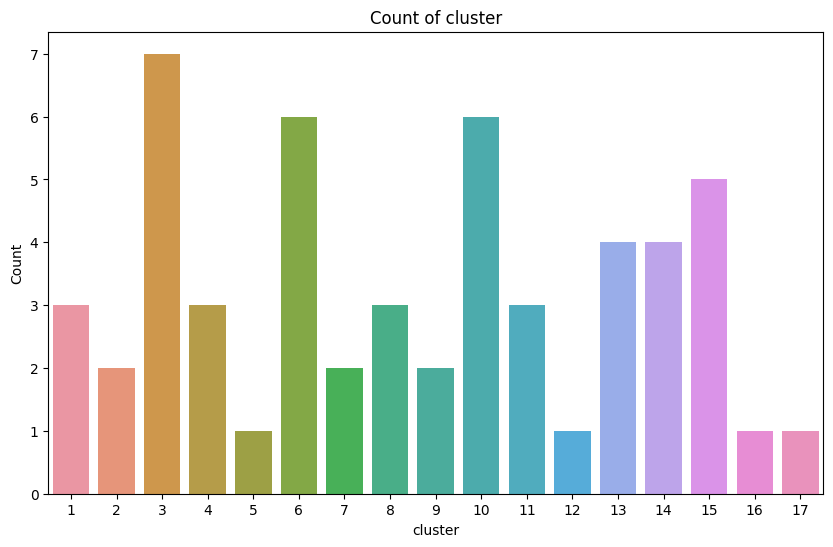

In [24]:
#exploring cluster column
plt.figure(figsize=(10, 6))  
sns.countplot(data=stores, x="cluster")
plt.title(f'Count of {"cluster"}')
plt.xlabel("cluster")
plt.ylabel('Count')
plt.show()


There are 17 unique clusters with cluster 3 having the highest

In [25]:
#exploring state column
stores.state.value_counts()

state
Pichincha                         19
Guayas                            11
Santo Domingo de los Tsachilas     3
Azuay                              3
Manabi                             3
Cotopaxi                           2
Tungurahua                         2
Los Rios                           2
El Oro                             2
Chimborazo                         1
Imbabura                           1
Bolivar                            1
Pastaza                            1
Santa Elena                        1
Loja                               1
Esmeraldas                         1
Name: count, dtype: int64

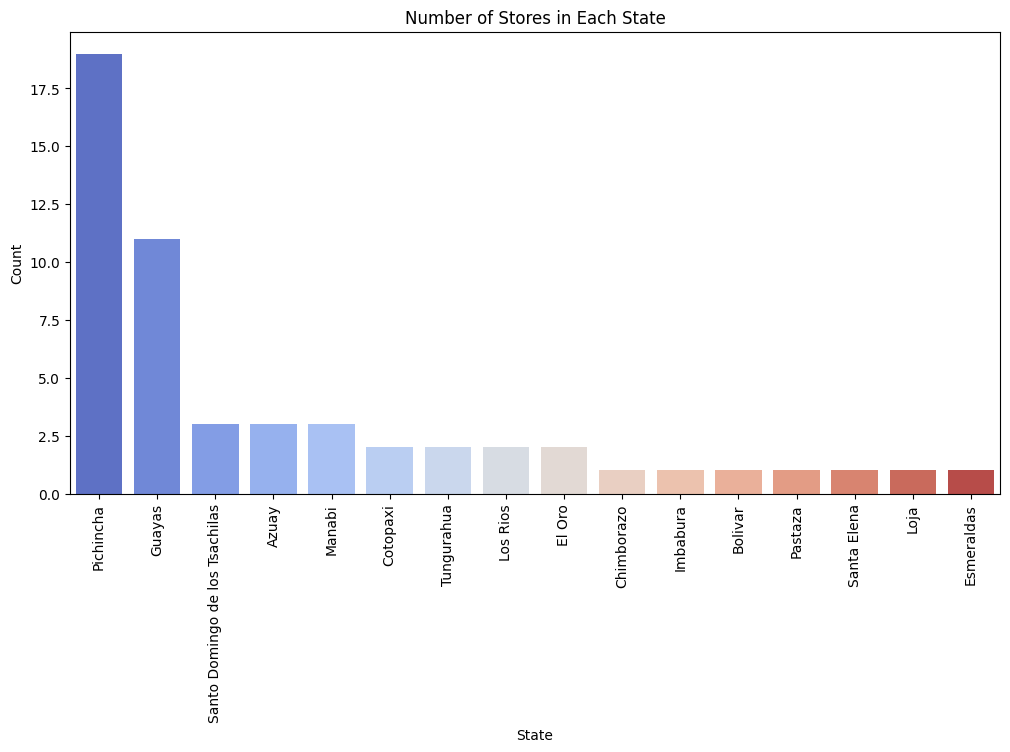

In [26]:
#Generate a graph
state_counts = stores['state'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=state_counts.index, y=state_counts.values, palette='coolwarm')
plt.title('Number of Stores in Each State')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()


There are 16 unique states with Pichincha having the highest number of stores

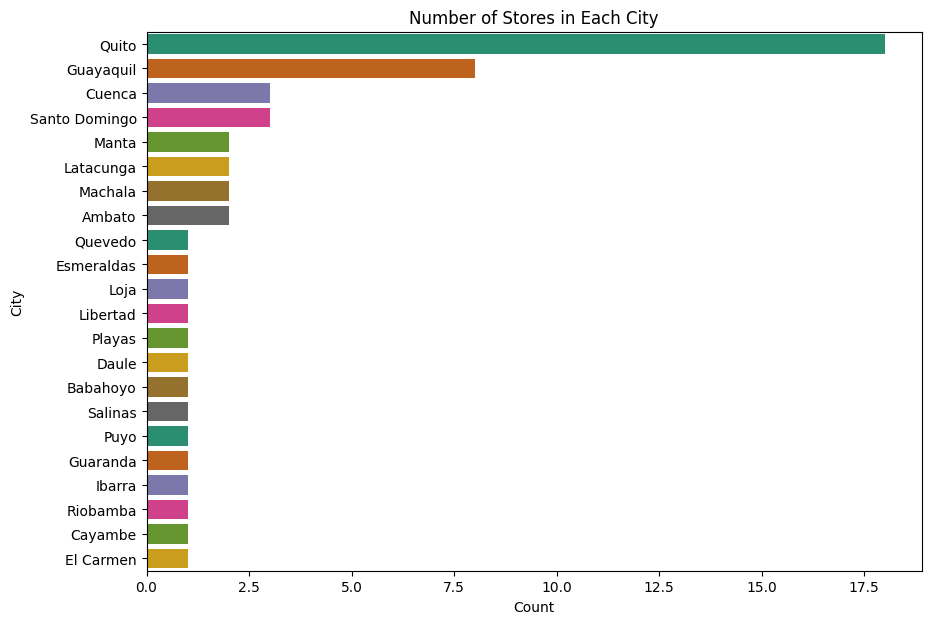

In [27]:
##exploring city column
city_counts = stores['city'].value_counts()

plt.figure(figsize=(10, 7))  
sns.barplot(x=city_counts.values, y=city_counts.index, palette='Dark2')
plt.title('Number of Stores in Each City')
plt.xlabel('Count')
plt.ylabel('City')
plt.show()


There are 22 unique cities with Quito having the highest count

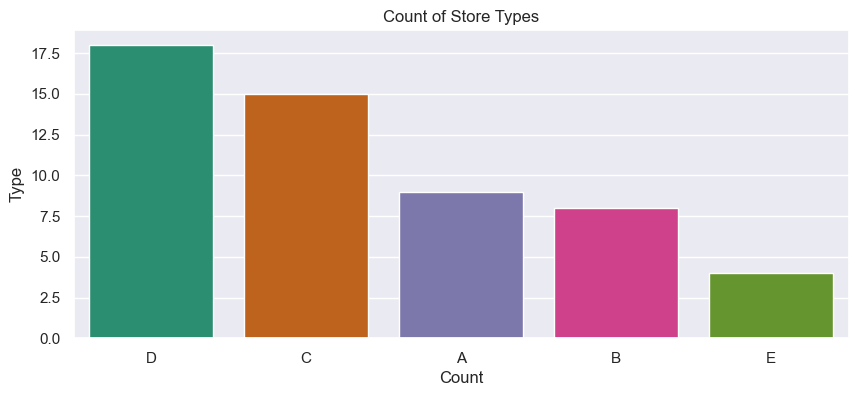

In [28]:
#exploring type column
type_counts = stores['type'].value_counts()

sns.set(rc={"figure.figsize": (10, 4)})
sns.barplot(x=type_counts.index, y=type_counts.values, palette="Dark2")
plt.title("Count of Store Types")
plt.xlabel("Count")
plt.ylabel("Type")
plt.show()


There are 5 unique store types with stores type D having the highest count

In [29]:
#exploring store_nbr
unique_values = len(stores['store_nbr'].unique())
print("Number of unique values in 'store_nbr':", unique_values)


Number of unique values in 'store_nbr': 54


In Summary:
- There are 17 unique clusters with cluster 3 having the highest count
- There are 16 unique states
- There are 22 unique cities with Quito having the highest count
- There are 54 unique stores Across 16 states and 22 cities
- There are 5 unique store types with stores type D having the highest count

### 2.1.3 Exploring the Transaction Dataset

In [30]:
trans.head()

date  store_nbr  transactions
0  2013-01-01         25           770
1  2013-01-02          1          2111
2  2013-01-02          2          2358
3  2013-01-02          3          3487
4  2013-01-02          4          1922

In [31]:
#we will convert the date to date time
trans['date'] = pd.to_datetime(trans['date'], format='%Y-%m-%d')

In [32]:
##make a copy of the transcation data incase a mistake is made
#this copy will be used for the exploration
trans_c=trans.copy()

In [33]:
##checking range of dates
trans_c["date"].min(),trans_c["date"].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))

In [34]:
##the date will be set as an index for analysis
trans_c=trans_c.set_index("date")

In [35]:
#view transaction column with date as index
trans_c.head()

store_nbr  transactions
date                               
2013-01-01         25           770
2013-01-02          1          2111
2013-01-02          2          2358
2013-01-02          3          3487
2013-01-02          4          1922

### Plotting our transaction Time series

In [36]:
##plot our transcation time series for insights
fig = px.line(trans_c, x=trans_c.index, y='transactions', title='Time Series with Slider')
fig.update_xaxes(rangeslider_visible=True)
fig.show()


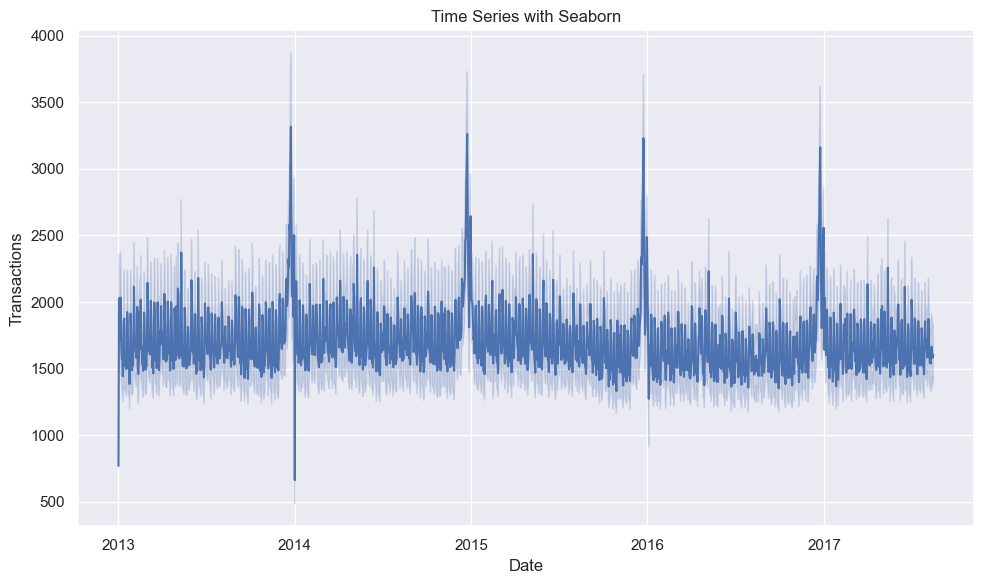

In [37]:

##using seaborn so the visual appears on github
plt.figure(figsize=(10, 6))
sns.lineplot(data=trans_c, x=trans_c.index, y='transactions')
plt.title('Time Series with Seaborn')
plt.xlabel('Date')
plt.ylabel('Transactions')

plt.tight_layout()

plt.show()


#### Notes 

- We can see some spikes in transactions at the begining of each year it could be due to seasonal pattern in the data. We will resample for further investigations and better understand the data

### Checking for outliers in transactions data


<Axes: >

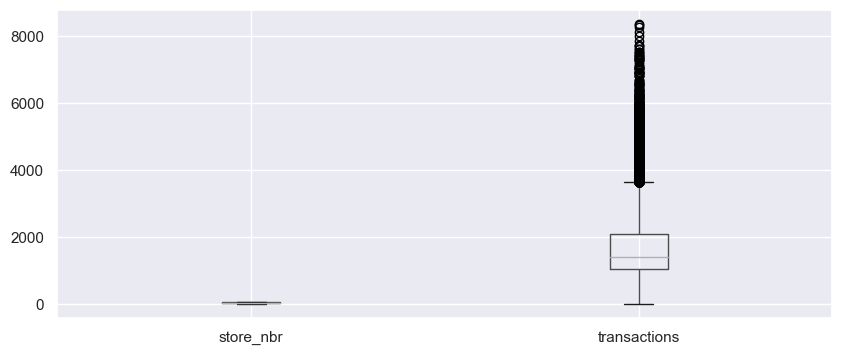

In [38]:
# check for outliers
trans.boxplot()

#### Notes after Checking for outliers:

- There are outliers therefore, when plotting our resampled values, we will use median values for our analysis instead of the mean.

### Resampling transcation data

In [39]:
## we will resample by months with median
month_trans=trans_c.drop(labels= "store_nbr",axis= 1).resample("M").median()

In [40]:
#view monthly transcations
month_trans.head()

transactions
date                    
2013-01-31        1386.0
2013-02-28        1403.5
2013-03-31        1424.0
2013-04-30        1423.5
2013-05-31        1424.0

In [41]:
#plot our transcation time series for insights
fig = px.line(month_trans, x=month_trans.index, y='transactions', title='Monthly transcations with Slider')
fig.update_xaxes(rangeslider_visible=True)
fig.show()


<Axes: xlabel='date'>

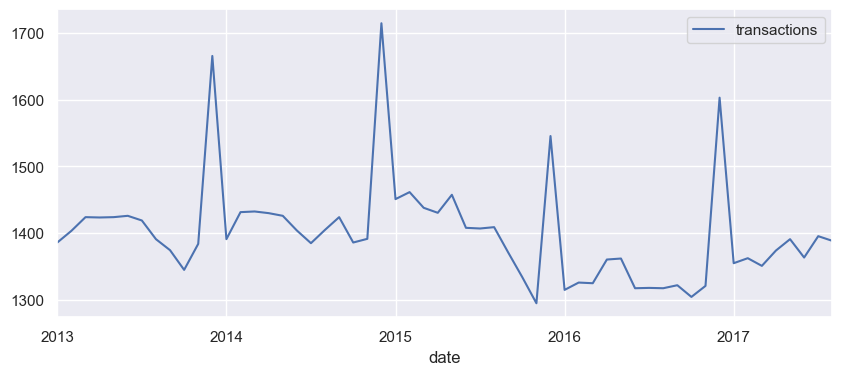

In [42]:
#using this visual so it appears on github
month_trans.plot()

### Notes:
* The transaction dataset exhibits a recurring pattern of seasonality, with a noticeable spike in transactions occurring on the 31st of December every year.
* Additionally, a minor increase in transactions is observed on the 31st of May in each year.
* In 2016, there is a noticeable but relatively modest decrease in transaction activity.

In [43]:
## explore store_nbr column
trans_c["store_nbr"].unique()

array([25,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 23, 24, 26, 27, 28, 30, 31, 32, 33, 34, 35, 37, 38, 39,
       40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 54, 36, 53, 20, 29, 21,
       42, 22, 52], dtype=int64)

Text(0.5, 1.0, 'Top 10 Store with the Highest Transactions')

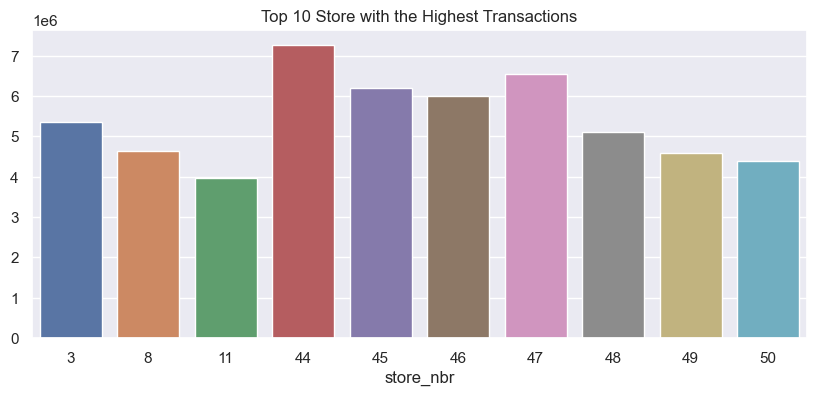

In [44]:
#view top 10 stores with highest transactions
store_tran= trans_c.groupby("store_nbr")["transactions"].agg("sum").sort_values(ascending= False).head(10)

sns.barplot(x=store_tran.index, y=store_tran.values)


plt.title('Top 10 Store with the Highest Transactions')

### Summary of Transaction Dataset:
- The store dataset had some seasonality with a spike in sales on every 23rd of December
- store number 44 had the highest number of transactions
- There are some outliers in the transactions

### 2.1.4 Exploring the Holidays Dataset

In [45]:
holidays_events.head()

date     type    locale locale_name                    description  \
0 2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1 2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2 2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3 2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4 2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False

In [46]:
#we will convert the date to date time
holidays_events['date'] = pd.to_datetime(holidays_events['date'], format='%Y-%m-%d')

In [47]:
##explore holiday type column
###make a copy to not lose data mistakenly
holi_c=holidays_events.copy()


In [48]:
##checking range of dates
holi_c["date"].min(),holi_c["date"].max()

(Timestamp('2012-03-02 00:00:00'), Timestamp('2017-12-26 00:00:00'))

In [49]:
holi_c["type"].value_counts()

type
Holiday       221
Event          56
Additional     51
Transfer       12
Bridge          5
Work Day        5
Name: count, dtype: int64

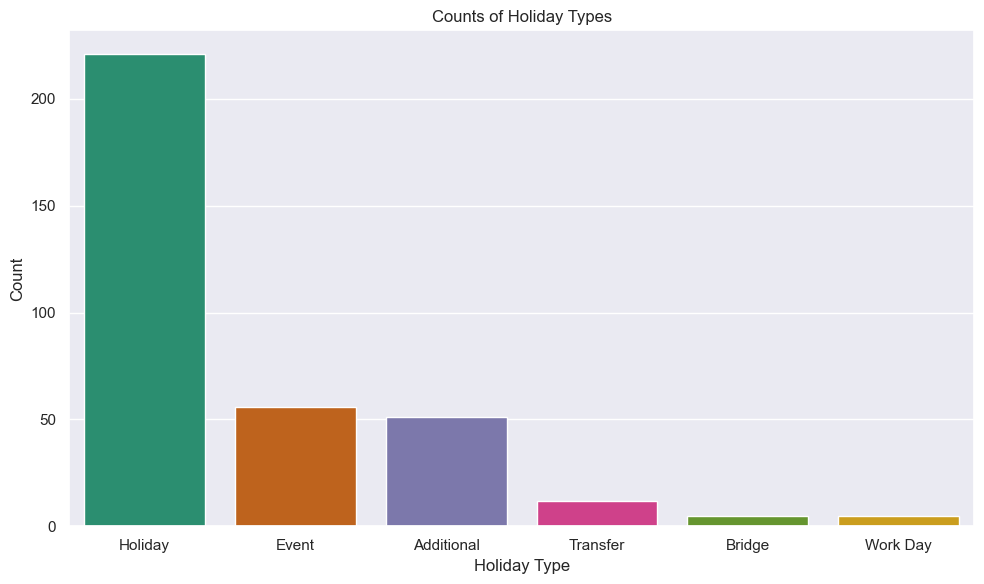

In [50]:
# Get the value counts of the "type" column
type_counts = holi_c["type"].value_counts()

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=type_counts.index, y=type_counts.values, palette="Dark2")
plt.title('Counts of Holiday Types')
plt.xlabel('Holiday Type')
plt.ylabel('Count')
plt.tight_layout()

plt.show()


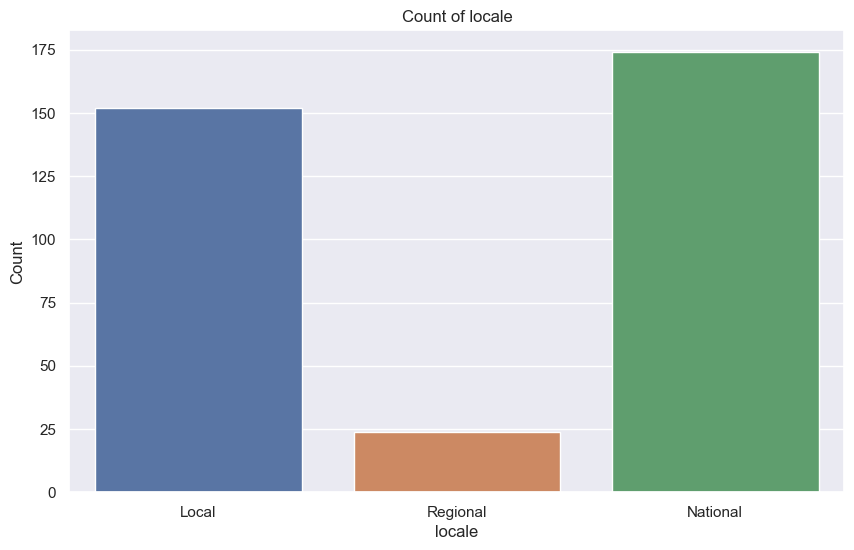

In [51]:
#explore locale column

##Let's see which locale has the highest number of holidays
plt.figure(figsize=(10, 6))  
sns.countplot(data=holi_c, x="locale")
plt.title(f'Count of {"locale"}')
plt.xlabel("locale")
plt.ylabel('Count')
plt.show()


In [52]:
##explore transferred column
holi_c["transferred"].value_counts()

transferred
False    338
True      12
Name: count, dtype: int64

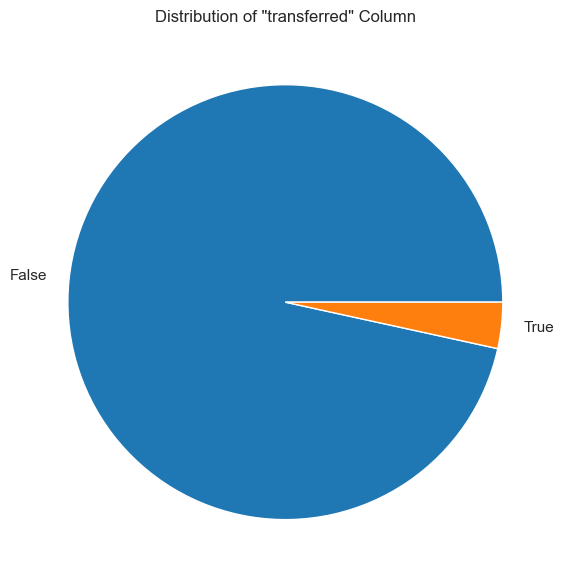

In [53]:

# Get the value counts of the "transferred" column
transferred_counts = holi_c["transferred"].value_counts()

# Create a pie chart using matplotlib
plt.figure(figsize=(6, 6))
plt.pie(transferred_counts, labels=transferred_counts.index,  colors=['#1f77b4', '#ff7f0e'])
plt.title('Distribution of "transferred" Column')
plt.tight_layout()

plt.show()


#### Summary of the Holiday Column:

- The majority of holidays were classified as national holidays.
- The majority of holidays were celebrated on the same day they occurred.
- With the exception of 12 holidays, most of the holidays were not marked as transferred.

### Exploring the Oil Dataset

In [54]:
oil.head()

date  dcoilwtico
0 2013-01-01         NaN
1 2013-01-02   93.139999
2 2013-01-03   92.970001
3 2013-01-04   93.120003
4 2013-01-07   93.199997

In [55]:
#we will convert the date to date time
oil['date'] = pd.to_datetime(oil['date'], format='%Y-%m-%d')


In [56]:
##checking range of dates
oil["date"].min(),oil["date"].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-31 00:00:00'))

In [57]:
#create a copy
oil_c=oil.copy()

In [58]:
##set date as index  
oil_c= oil_c.set_index("date")

In [59]:
#view oil
oil_c.head()

dcoilwtico
date                  
2013-01-01         NaN
2013-01-02   93.139999
2013-01-03   92.970001
2013-01-04   93.120003
2013-01-07   93.199997

From our data overview,we noticed that the dcoilwtico column in the oil dataset has missing values.Since the first value is missing it will good to use backward fill to fill the missing values

In [60]:
oil_c.isnull().sum()

dcoilwtico    43
dtype: int64

In [61]:
##using backward fil
oil_c["dcoilwtico"].fillna(method= "bfill",inplace=True)


In [62]:
##let view oil dataset after filling the values
oil_c.head()

dcoilwtico
date                  
2013-01-01   93.139999
2013-01-02   93.139999
2013-01-03   92.970001
2013-01-04   93.120003
2013-01-07   93.199997

In [63]:
#check number of mising values
oil_c.isnull().sum()

dcoilwtico    0
dtype: int64

In [64]:
#plot our oil time series for insights
fig = px.line(oil_c, x=oil_c.index, y='dcoilwtico')
fig.update_xaxes(rangeslider_visible=True)
fig.show()


<Axes: xlabel='date'>

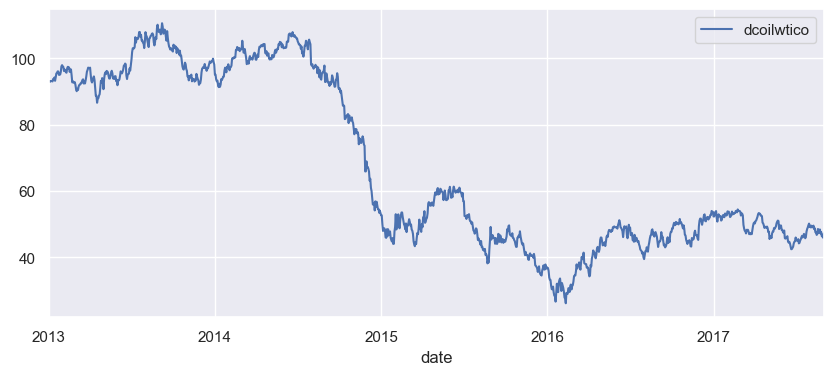

In [65]:
##using matplotlib visual appears on github
oil_c.plot()

#### Summary of the oil  dataset:
- There was a price drop from 2014 to 2017

### Exploring the train dataset

In [66]:
train.head()

id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0

In [67]:
#we will convert the date to date time
train['date'] = pd.to_datetime(train['date'], format='%Y-%m-%d')


In [68]:
##checking range of dates
train["date"].min(),train["date"].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))

In [69]:
## Creating a copy to ensure we can retrive the orginal dataframe incase of an error during our analysis
train_c=train.copy()

In [70]:
#set date as index
train_c=train_c.set_index("date")

In [71]:
#view train data
train_c.head()

id  store_nbr      family  sales  onpromotion
date                                                     
2013-01-01   0          1  AUTOMOTIVE    0.0            0
2013-01-01   1          1   BABY CARE    0.0            0
2013-01-01   2          1      BEAUTY    0.0            0
2013-01-01   3          1   BEVERAGES    0.0            0
2013-01-01   4          1       BOOKS    0.0            0

## Univariate Analysis

####  Checking the distribution of the train dataset

array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'store_nbr'}>],
       [<Axes: title={'center': 'sales'}>,
        <Axes: title={'center': 'onpromotion'}>]], dtype=object)

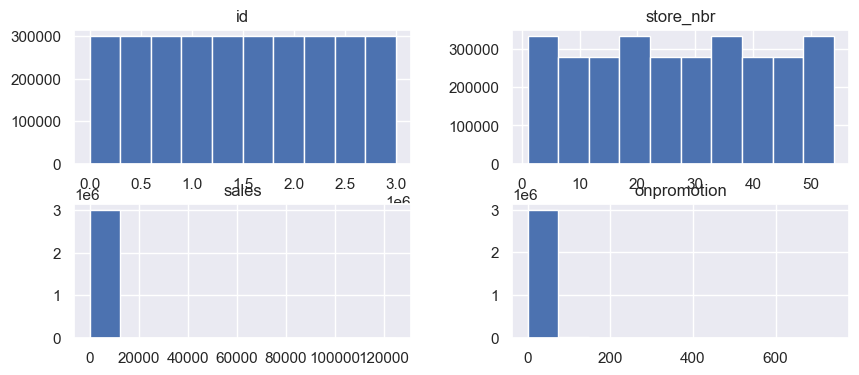

In [72]:
train_c.hist()

### Checking for outliers

<Axes: >

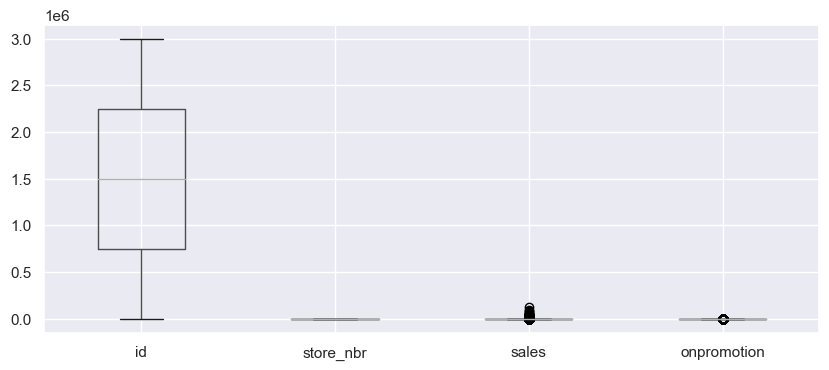

In [73]:
train_c.boxplot()

### Notes
* Sales column contain some outliers

In [74]:
## exploring family column

In [75]:
train_c["family"].value_counts()

family
AUTOMOTIVE                    90936
HOME APPLIANCES               90936
SCHOOL AND OFFICE SUPPLIES    90936
PRODUCE                       90936
PREPARED FOODS                90936
POULTRY                       90936
PLAYERS AND ELECTRONICS       90936
PET SUPPLIES                  90936
PERSONAL CARE                 90936
MEATS                         90936
MAGAZINES                     90936
LIQUOR,WINE,BEER              90936
LINGERIE                      90936
LAWN AND GARDEN               90936
LADIESWEAR                    90936
HOME CARE                     90936
HOME AND KITCHEN II           90936
BABY CARE                     90936
HOME AND KITCHEN I            90936
HARDWARE                      90936
GROCERY II                    90936
GROCERY I                     90936
FROZEN FOODS                  90936
EGGS                          90936
DELI                          90936
DAIRY                         90936
CLEANING                      90936
CELEBRATION          

## Notes
The uniform count across all families is logical since even on days with no purchases, the product's family is still represented in the dataset.

<Axes: xlabel='date'>

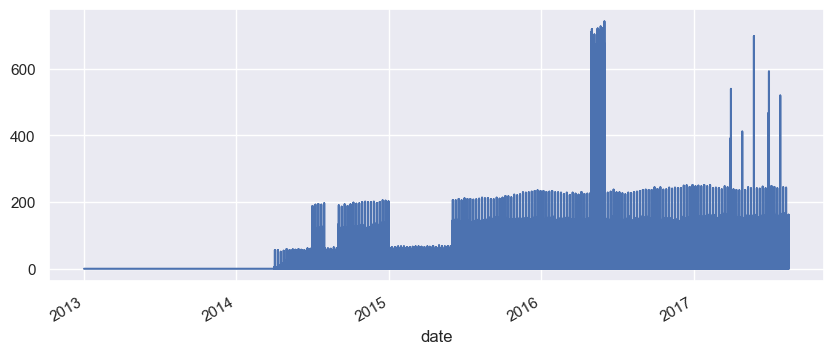

In [76]:
## exploring on promotion column
train_c["onpromotion"].plot()

In [77]:
##resample on promotion by day
daily_promo=train_c["onpromotion"].resample("D").mean()


In [78]:
#plot our  time series for insights
fig = px.line(daily_promo, x=daily_promo.index, y='onpromotion',title=("Daily Promotions"))

fig.update_xaxes(rangeslider_visible=True)
fig.show()


<Axes: xlabel='date'>

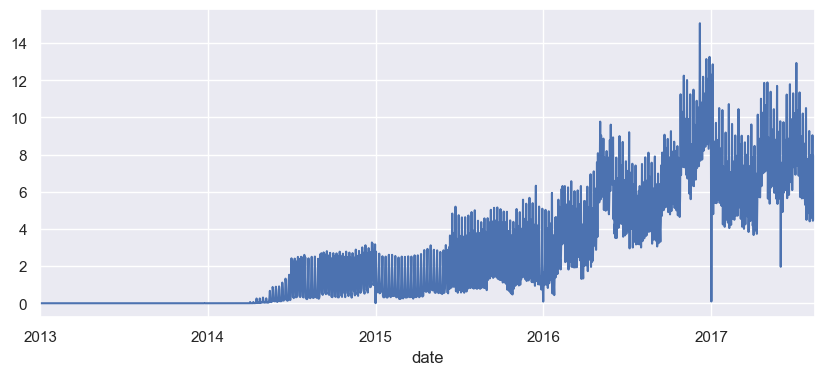

In [79]:
daily_promo.plot()

### Notes
- From 2013 to 2014, no promotions were recorded.
- Promotional activities showed an increase in both 2016 and 2017.
- There was a noticeable decline in promotions at the start of each year between 2015 and 2016.

In [80]:
##Let's see what happened each month
month_promo=train_c[["onpromotion"]].resample("M").mean()

In [81]:

fig = px.line(month_promo, x=month_promo.index, y='onpromotion',title=("Monthly Promotions"))

fig.update_xaxes(rangeslider_visible=True)
fig.show()


<Axes: xlabel='date'>

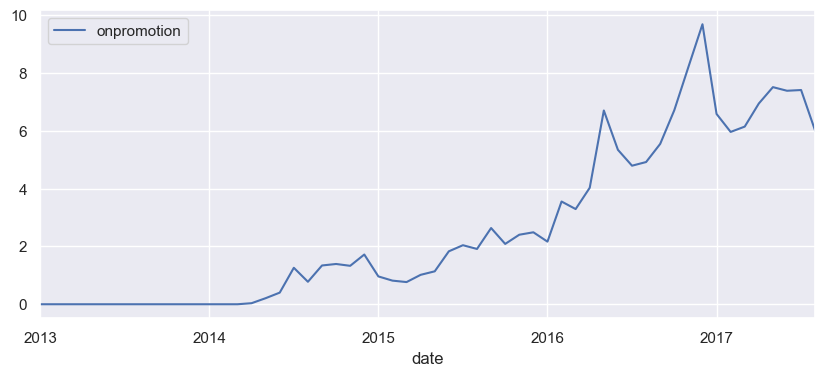

In [82]:
month_promo.plot()

#### Notes of promotion after resmapling on promotion by month:
- Promotions experienced a reduction from January to May in 2015.
- A significant surge in promotions occurred from April 30th in 2016, possibly attributed to the earthquake event.
    

#### Exploring the Sales Attribute

Text(0.5, 1.0, 'Sales with respect to Time')

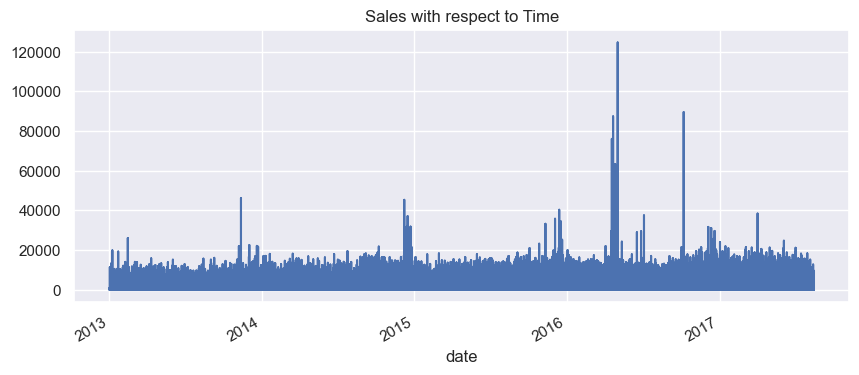

In [83]:
train_c.sales.plot()
plt.title("Sales with respect to Time")

Given the apparent variability in the graph displayed above, I intend to perform resampling on various time scales, including daily, weekly and  monthly intervals. This will allow me to analyze how the sales pattern evolves over different time periods.

<Axes: title={'center': 'Daily Sales'}, xlabel='date'>

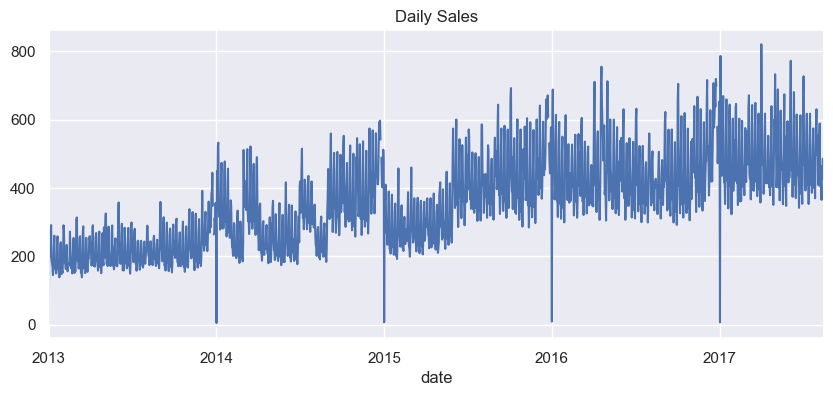

In [84]:
##daily resampling
sale_daily=train_c["sales"].resample("D").mean()

plt.title("Daily Sales")

sale_daily.plot()

## Notes
- A noticeable overall upward trend is evident.
- Sales experience a decline at the start of each year.

<Axes: title={'center': 'Weekly Sales'}, xlabel='date'>

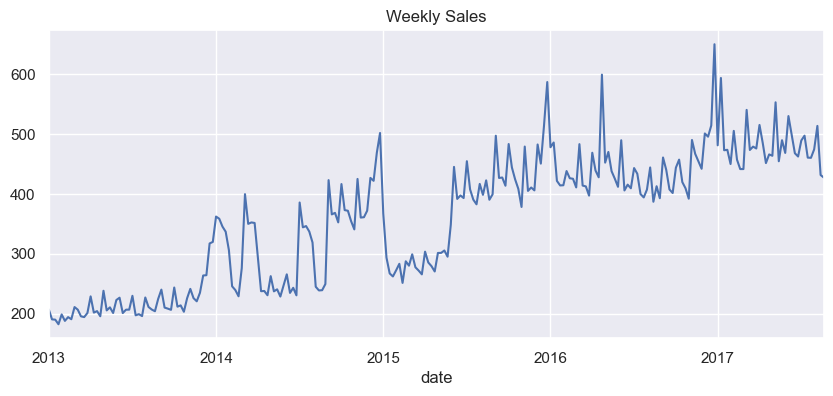

In [85]:
#weekly resampling
sale_weekly=train_c["sales"].resample("W").mean()

plt.title("Weekly Sales")

sale_weekly.plot()

## Notes
The trend becomes evident when resampled weekly

<Axes: title={'center': 'Monthly Average sales for Favorita'}, xlabel='date'>

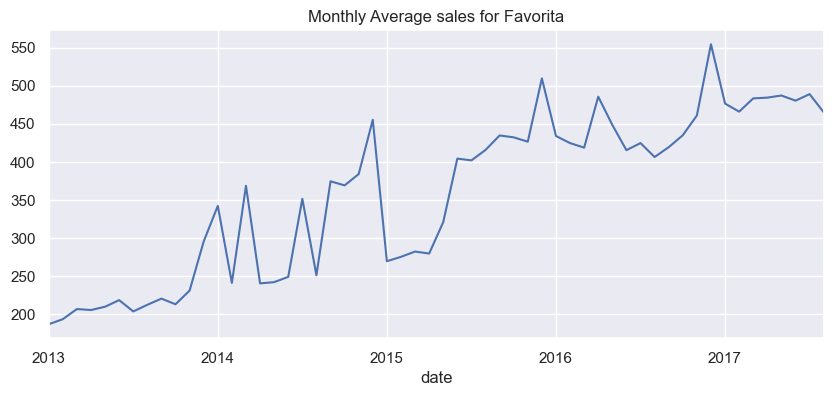

In [86]:
sale_monthly=train_c["sales"].resample("M").mean()

plt.title("Monthly Average sales for Favorita")

sale_monthly.plot()

A trend can also be seen when resampled monthly

## Multivariate Analysis

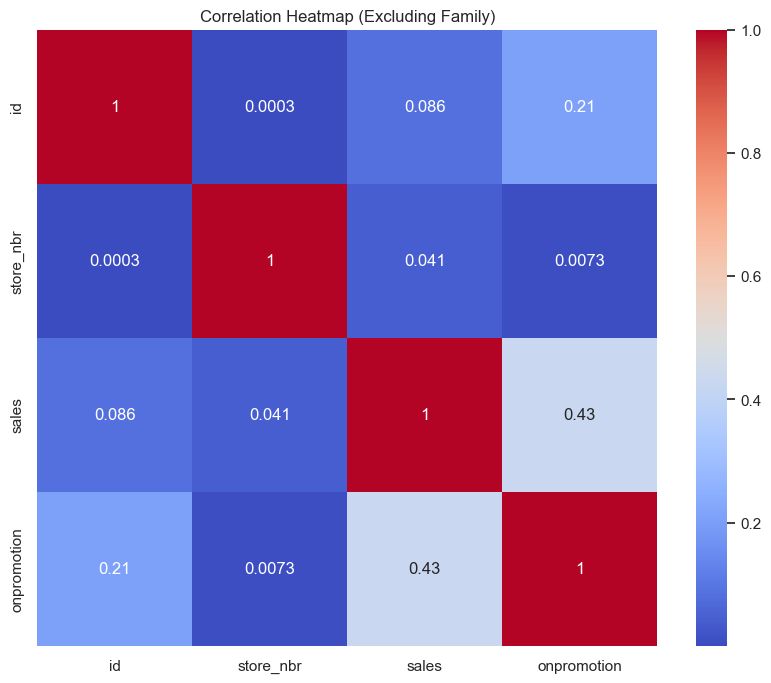

In [87]:
# Exclude the 'family' column
corr_matrix = train_c.drop(columns=['family']).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap (Excluding Family)')
plt.show()


## Merging The Dataframes

We will only be considering:
 
- transaction
- oil
- train
- holidays
 
 
Also, since we have our target(sales) in the transaction column, we are going to filter all other datasets (from 2013-01-01 to 2017-08-15) to match the date of our train dataset. This approach will enable us to assess the impact of various variables on our sales within the same timeframe.

Additionally, we will exclude the 'store' dataset from our analysis. Our objective is not to predict sales for individual products across specific stores. Instead, we aim to forecast unit sales across all stores within the Favorita.

### Filter out dates that are only in our Train data

In [88]:
trans_train= trans[(trans["date"]>="2013-01-01") & (trans["date"]<= "2017-08-15")]
oil_train= oil[(oil["date"]>="2013-01-01") & (oil["date"]<= "2017-08-15")]
holiday_train= holidays_events[(holidays_events["date"]>="2013-01-01") & (holidays_events["date"]<= "2017-08-15")]

In [89]:
## Now we merge the datasets
merge_data1= pd.merge(train, trans_train, how= "outer", on= ["date", "store_nbr"])

merge_data2= pd.merge(merge_data1, holiday_train, how= "outer", on= "date")

merge_data3=  pd.merge(merge_data2, oil_train, how= "outer", on= "date")

In [90]:
#view merged data
merge_data3.head()

id       date  store_nbr      family  sales  onpromotion  transactions  \
0  0.0 2013-01-01        1.0  AUTOMOTIVE    0.0          0.0           NaN   
1  1.0 2013-01-01        1.0   BABY CARE    0.0          0.0           NaN   
2  2.0 2013-01-01        1.0      BEAUTY    0.0          0.0           NaN   
3  3.0 2013-01-01        1.0   BEVERAGES    0.0          0.0           NaN   
4  4.0 2013-01-01        1.0       BOOKS    0.0          0.0           NaN   

      type    locale locale_name         description transferred  dcoilwtico  
0  Holiday  National     Ecuador  Primer dia del ano       False         NaN  
1  Holiday  National     Ecuador  Primer dia del ano       False         NaN  
2  Holiday  National     Ecuador  Primer dia del ano       False         NaN  
3  Holiday  National     Ecuador  Primer dia del ano       False         NaN  
4  Holiday  National     Ecuador  Primer dia del ano       False         NaN

In [91]:
merge_data3.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054352 entries, 0 to 3054351
Data columns (total 13 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            float64       
 1   date          datetime64[ns]
 2   store_nbr     float64       
 3   family        object        
 4   sales         float64       
 5   onpromotion   float64       
 6   transactions  float64       
 7   type          object        
 8   locale        object        
 9   locale_name   object        
 10  description   object        
 11  transferred   object        
 12  dcoilwtico    float64       
dtypes: datetime64[ns](1), float64(6), object(6)
memory usage: 302.9+ MB


In [95]:
# Create a copy of the merged data
merged_data_copy = merge_data3.copy()



**Hypothesis Testing using T-Test**

A **t-test** is a statistical hypothesis test used to determine if there is a significant difference between the means of two groups. It helps you assess whether the observed differences between the groups' sample means are likely to have occurred due to random chance or if they are statistically significant.


Hypothesis: Promotion Intensity

**Null Hypothesis (H0):** The intensity of promotion (onpromotion) does not have a significant impact on the average sales of products.

**Alternative Hypothesis (H1):** The intensity of promotion (onpromotion) has a significant impact on the average sales of products.

In [97]:
# Split onpromotion variable into promoted products and non-promoted products
promoted_data = merge_data3[merge_data3['onpromotion'] >= 1]
non_promoted_data = merge_data3[merge_data3['onpromotion'] < 1]


In [103]:
# Calculate average sales for promoted and non-promoted products
average_sales_promoted = promoted_data['sales'].mean()
average_sales_non_promoted = non_promoted_data['sales'].mean()

# Perform a t-test
t_statistic, p_value = stats.ttest_ind(promoted_data['sales'], non_promoted_data['sales'], equal_var=False)

# Determine the significance level (alpha)
alpha = 0.05

# Check if the p-value is less than the significance level
if p_value < alpha:
    result = "Reject the null hypothesis"
else:
    result = "Fail to reject the null hypothesis"

# Print the results with p-value formatted to three decimal places
print("Average sales for promoted products:", average_sales_promoted)
print("Average sales for non-promoted products:", average_sales_non_promoted)
print("T-statistic:", t_statistic)
print(f"P-value: {p_value:.3f}")  # Format p-value to three decimal places
print("Conclusion:", result)

Average sales for promoted products: 1139.8286947893275
Average sales for non-promoted products: 157.81047220093524
T-statistic: 395.83372114047893
P-value: 0.000
Conclusion: Reject the null hypothesis


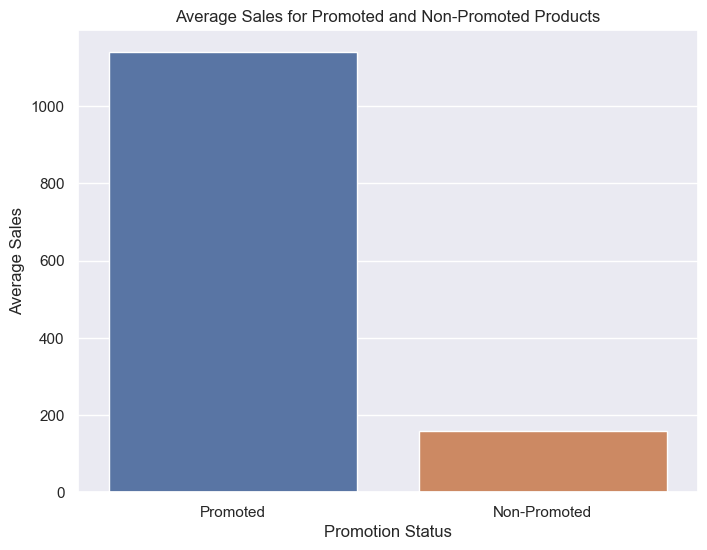

In [102]:
# Calculate average sales for promoted and non-promoted products
average_sales_promoted = promoted_data['sales'].mean()
average_sales_non_promoted = non_promoted_data['sales'].mean()

# Create a bar plot using seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x=['Promoted', 'Non-Promoted'], y=[average_sales_promoted, average_sales_non_promoted])
plt.xlabel('Promotion Status')
plt.ylabel('Average Sales')
plt.title('Average Sales for Promoted and Non-Promoted Products')
plt.show()


- The average sales for promoted products is approximately 1139.83.
- The average sales for non-promoted products is approximately 157.81.
- The calculated t-statistic is approximately 395.83.
- The calculated p-value is 0.000

The average sales for promoted products is higher than the average sales for non-promoted products

Based on the p-value being significantly lower than the significance level of 0.05, we can reject the null hypothesis. This suggests that there is a significant difference between the average sales of promoted products and non-promoted products. In other words, the presence of promotions has a statistically significant positive effect on the sales of products.

**Questions** 

**Question 1:** Which dates have the lowest and highest sales for each year?

In [111]:
# Assuming 'merge_data3' is your merged dataset with relevant columns including 'date' and 'sales'
# Make sure to convert 'date' to datetime type if it's not already
merge_data3['date'] = pd.to_datetime(merge_data3['date'])

# Extract year from the 'date' column
merge_data3['year'] = merge_data3['date'].dt.year

# Group by year and calculate min and max sales
yearly_sales_stats = merge_data3.groupby('year')['sales'].agg([('min_sales', 'min'), ('max_sales', 'max')])

# Find the dates with lowest and highest sales for each year
lowest_sales_dates = merge_data3.loc[merge_data3.groupby('year')['sales'].idxmin(), ['year', 'date', 'sales']]
highest_sales_dates = merge_data3.loc[merge_data3.groupby('year')['sales'].idxmax(), ['year', 'date', 'sales']]

# Display the results
print("\nDates with Lowest Sales for Each Year:")
print(lowest_sales_dates)

print("\nDates with Highest Sales for Each Year:")
highest_sales_dates




Dates with Lowest Sales for Each Year:
         year       date  sales
0        2013 2013-01-01    0.0
657558   2014 2014-01-01    0.0
1316898  2015 2015-01-01    0.0
1972674  2016 2016-01-01    0.0
2642706  2017 2017-01-01    0.0

Dates with Highest Sales for Each Year:


year       date       sales
569724   2013 2013-11-12   46271.000
1273284  2014 2014-12-08   45361.000
1941534  2015 2015-12-14   40351.460
2194017  2016 2016-05-02  124717.000
2806629  2017 2017-04-02   38422.625

**Dates with lowest sales for each year**

This data indicates that on the dates mentioned, the sales were at their lowest, and the sales value recorded for those dates was 0.0 for all years (2013, 2014, 2015, 2016, and 2017). This could be due to various factors such as holidays, special events, or other circumstances that led to lower sales activity on those specific dates.

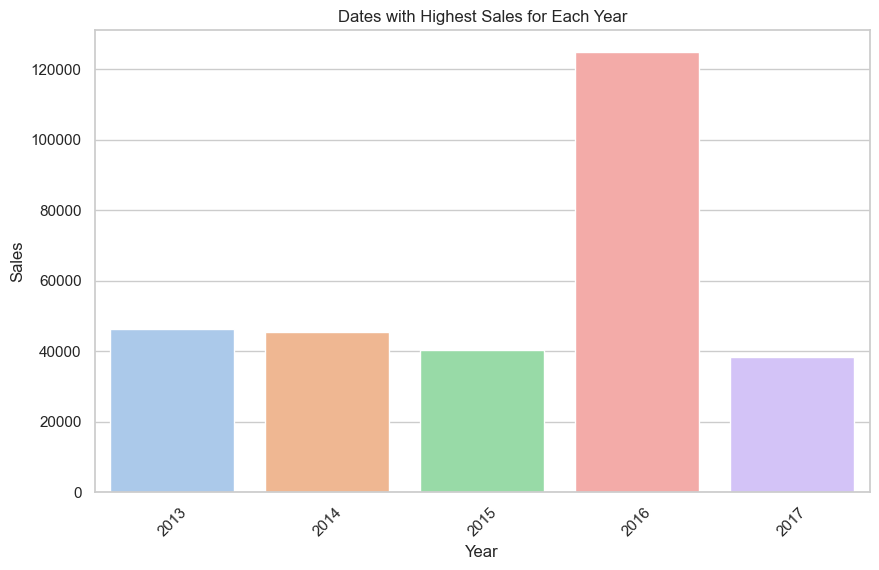

In [117]:
# Create a DataFrame with the given data
data = {
    'year': [2013, 2014, 2015, 2016, 2017],
    'date': ['2013-11-12', '2014-12-08', '2015-12-14', '2016-05-02', '2017-04-02'],
    'sales': [46271.0, 45361.0, 40351.46, 124717.0, 38422.625]
}
df = pd.DataFrame(data)

# Convert 'date' column to datetime type
df['date'] = pd.to_datetime(df['date'])

# Set Seaborn style
sns.set(style="whitegrid")

# Define a color palette
colors = sns.color_palette("pastel")

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='year', y='sales', data=df, palette=colors)
plt.xlabel('Year')
plt.ylabel('Sales')
plt.title('Dates with Highest Sales for Each Year')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()

**Dates with highest sales for each year**

- In the year 2013, the highest sales of 46,271.000 occurred on November 12, 2013.
- In the year 2014, the highest sales of 45,361.000 occurred on December 8, 2014.
- In the year 2015, the highest sales of 40,351.460 occurred on December 14, 2015.
- In the year 2016, the highest sales of 124,717.000 occurred on May 2, 2016.
- In the year 2017, the highest sales of 38,422.625 occurred on April 2, 2017.

These dates represent the days with the highest sales values in each respective year. This information can be valuable for understanding trends in sales performance and identifying potentially impactful events or promotions that led to these high sales days.

**Question 2:** Which stores are among the top 10 in terms of total sales?

Top 10 Stores by Total Sales:
store_nbr
44    6.208755e+07
45    5.449801e+07
47    5.094831e+07
3     5.048191e+07
49    4.342010e+07
46    4.189606e+07
48    3.593313e+07
51    3.291149e+07
8     3.049429e+07
50    2.865302e+07
Name: sales, dtype: float64


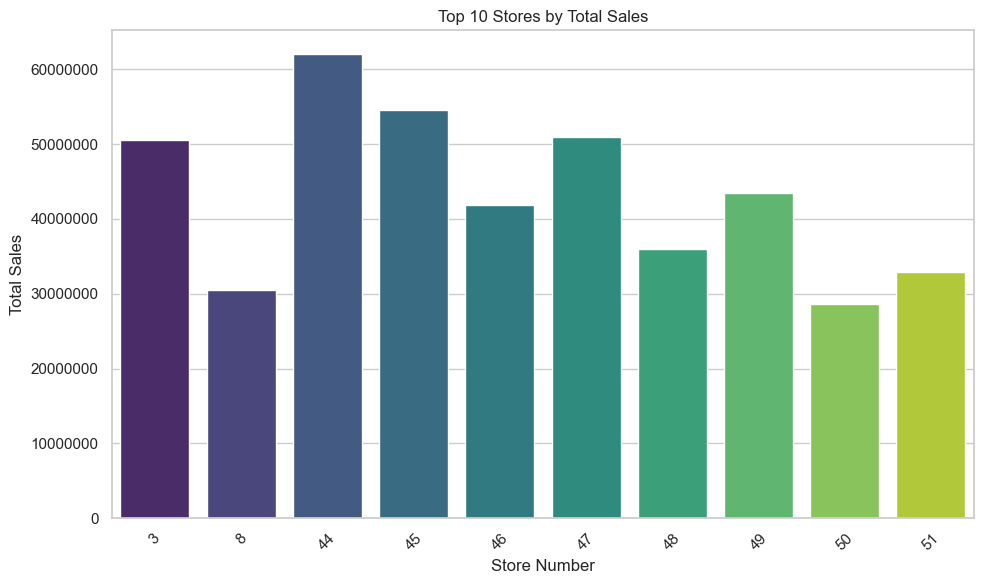

In [125]:
# Group data by store number and calculate total sales for each store
store_sales = train.groupby('store_nbr')['sales'].sum()

# Sort stores by total sales in descending order and select the top 10
top_10_stores = store_sales.sort_values(ascending=False).head(10)

# Display the top 10 stores and their total sales
print("Top 10 Stores by Total Sales:")
print(top_10_stores)

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_stores.index, y=top_10_stores.values, palette="viridis")
plt.title('Top 10 Stores by Total Sales')
plt.xlabel('Store Number')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.gca().get_yaxis().get_major_formatter().set_scientific(False)  # Prevent scientific notation
plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)  # Prevent offset notation
plt.tight_layout()
plt.show()


The store with store number 44 has at the highest total sales value of approximately 62,087,550, followed by the store with store number 45 of a total sales value of approximately 54,498,010. The lowest total sales is store number 50.  
This information gives us insight into the stores that have generated the highest total sales, helping us understand the distribution of sales among the top-performing stores.

**Question 3:** Did the sales data show any noticeable changes in sales patterns around the time of the 2016 earthquake?

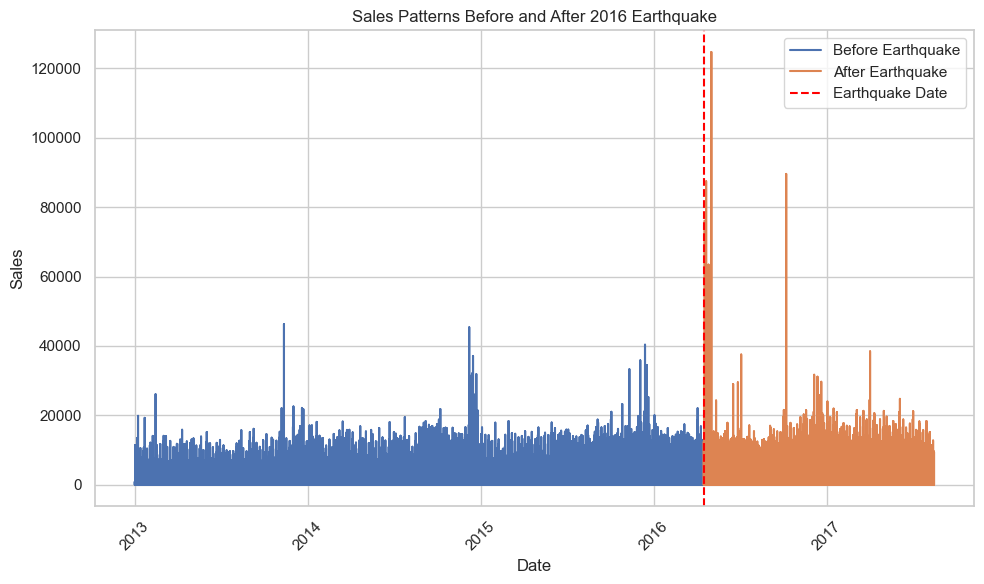

In [128]:
# Convert date column to datetime format
merge_data3['date'] = pd.to_datetime(merge_data3['date'])

# Filter sales data for the periods before and after the earthquake
sales_before_earthquake = merge_data3[merge_data3['date'] < '2016-04-16']
sales_after_earthquake = merge_data3[merge_data3['date'] >= '2016-04-16']

# Create a line plot for sales trends before and after the earthquake
plt.figure(figsize=(10, 6))
plt.plot(sales_before_earthquake['date'], sales_before_earthquake['sales'], label='Before Earthquake')
plt.plot(sales_after_earthquake['date'], sales_after_earthquake['sales'], label='After Earthquake')
plt.axvline(x=pd.to_datetime('2016-04-16'), color='red', linestyle='--', label='Earthquake Date')
plt.title('Sales Patterns Before and After 2016 Earthquake')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




The sales data showed some noticeable changes in sales patterns after the 2016 earthquake. Sales patterns changed significantly after the 2016 earthquake, with a noticeable spike in sales immediately following the event. This observation indicates that the earthquake might have had a significant impact on consumer behavior and purchasing patterns. 

**Question 4:** Which product families were the most frequently purchased (Top 5)?

Top 5 Families by Total Sales:
family
GROCERY I    3.434627e+08
BEVERAGES    2.169545e+08
PRODUCE      1.227047e+08
CLEANING     9.752129e+07
DAIRY        6.448771e+07
Name: sales, dtype: float64


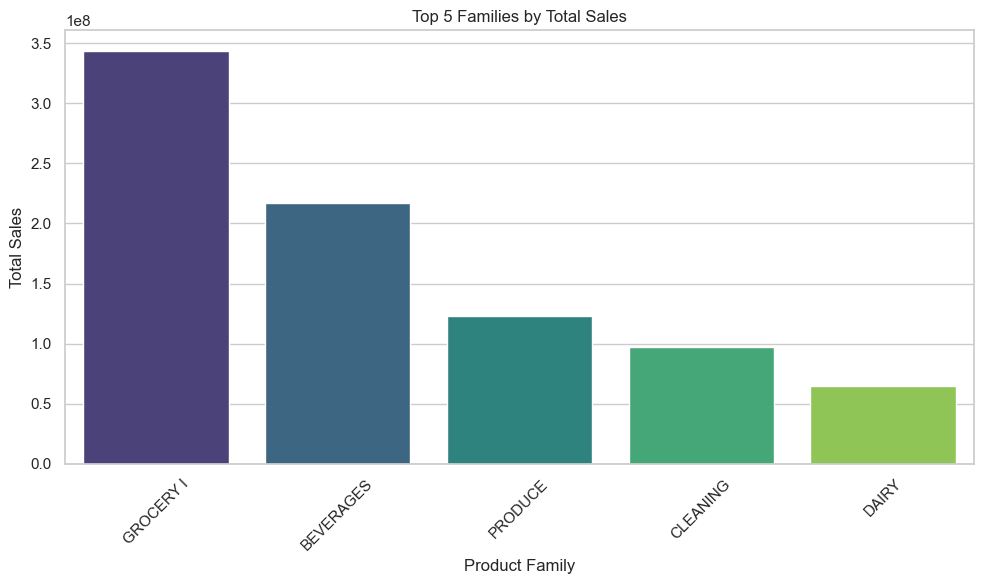

In [131]:
# Group data by family and calculate total sales for each family
family_sales = train.groupby('family')['sales'].sum()

# Sort families by total sales in descending order and select the top 5
top_5_families = family_sales.sort_values(ascending=False).head(5)

# Display the top 5 families and their total sales
print("Top 5 Families by Total Sales:")
print(top_5_families)

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=top_5_families.index, y=top_5_families.values, palette="viridis")
plt.title('Top 5 Families by Total Sales')
plt.xlabel('Product Family')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The "GROCERY I" family has the highest total sales, followed by "BEVERAGES," "PRODUCE," "CLEANING," and "DAIRY." These product families have significantly higher total sales compared to other families in the dataset. This information can be valuable for understanding customer preferences and optimizing product offerings in these top-performing categories.

**Question 5:** Is there a relationship between transactions and sales?

In [132]:
# Calculate the correlation between transactions and sales
correlation = merge_data3['transactions'].corr(merge_data3['sales'])

# Print the correlation value
print("Correlation between Transactions and Sales:", correlation)


Correlation between Transactions and Sales: 0.21484819600856747


The correlation coefficient between transactions and sales is approximately 0.215. This indicates a positive correlation between these two variables. A positive correlation means that as the number of transactions increases, the sales tend to increase as well. However, the correlation coefficient of 0.215 suggests that the relationship between transactions and sales is not very strong.

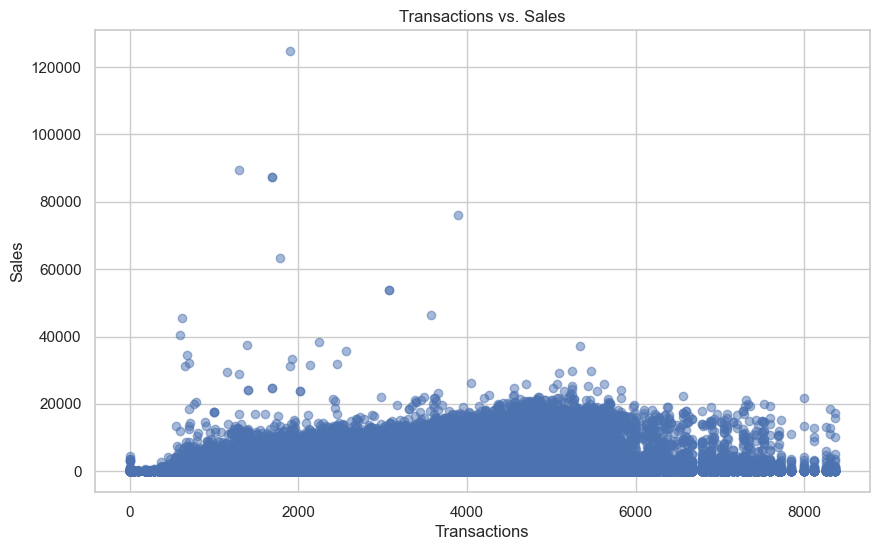

In [133]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(merge_data3['transactions'], merge_data3['sales'], alpha=0.5)
plt.title('Transactions vs. Sales')
plt.xlabel('Transactions')
plt.ylabel('Sales')
plt.show()


The scatter plot also supports this interpretation. The points on the scatter plot show a general trend of increasing sales with increasing transactions, but there is also a significant amount of variability in the data points, indicating that other factors may be influencing sales as well.

**Question 6:** Is there any association between oil prices and sales?

In [134]:
# Calculate the correlation between sales and oil prices
correlation_sales_oil = merge_data3['sales'].corr(merge_data3['dcoilwtico'])

# Print the correlation coefficient
print("Correlation between Sales and Oil Prices:", correlation_sales_oil)


Correlation between Sales and Oil Prices: -0.07939344970014041


The correlation coefficient between sales and oil prices is approximately -0.079. This value indicates a weak negative correlation between the two variables. In other words, as oil prices increase or decrease, there is a very slight tendency for sales to decrease or increase, respectively. However, the correlation is quite close to zero, which suggests that there is no strong linear relationship between sales and oil prices in the given data.

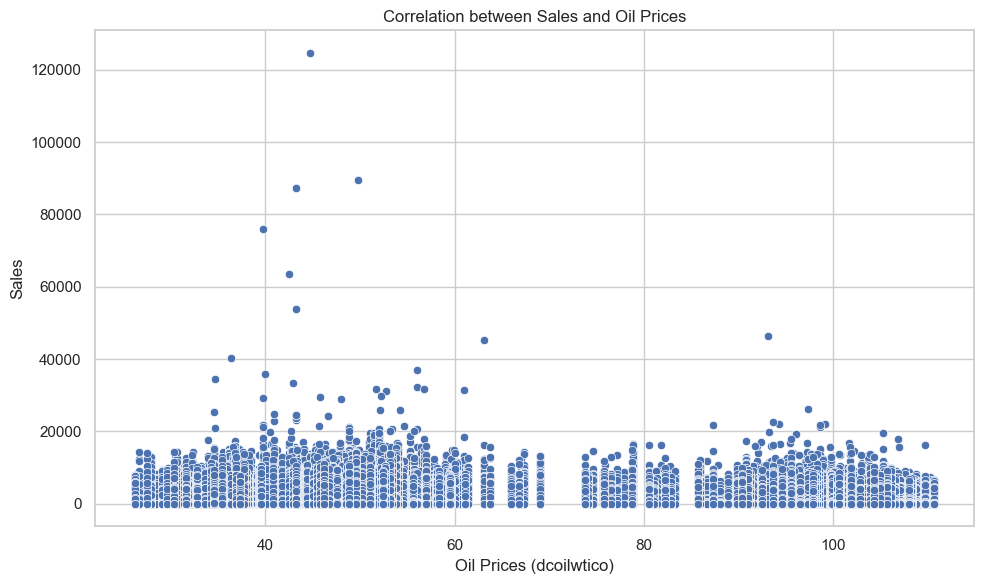

In [135]:
# Create a scatter plot to visualize the correlation
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merge_data3, x='dcoilwtico', y='sales')
plt.title('Correlation between Sales and Oil Prices')
plt.xlabel('Oil Prices (dcoilwtico)')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()

The points on the plot are scattered without a clear linear trend, indicating a weak relationship between these two variables. This observation is consistent with the correlation coefficient of approximately -0.08, which is close to zero. A correlation value close to zero suggests that there is little to no linear correlation between sales and oil prices.